In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv(r'..\Sun Light\train\train.csv')
test = pd.read_csv(r'..\Sun Light\test\1.csv') # From 1 to 80

In [3]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [4]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0
52559,1094,23,30,0,0,2.1,67.70,-4,0.0


Hour - 시간<br>
Minute - 분 <br>
DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2)) <br>
DNI - 직달일사량(Direct Normal Irradiance (W/m2)) <br>
WS - 풍속(Wind Speed (m/s)) <br>
RH - 상대습도(Relative Humidity (%)) <br>
T - 기온(Temperature (Degree C)) <br>
Target - 태양광 발전량 (kW) 

In [5]:
test.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.8,70.34,-6.1,0.0
1,0,0,30,0,0,2.9,71.97,-6.4,0.0
2,0,1,0,0,0,2.9,69.77,-6.7,0.0
3,0,1,30,0,0,2.9,71.95,-7.1,0.0
4,0,2,0,0,0,2.9,69.48,-7.4,0.0


In [6]:
train_wo_date = train.drop(columns=['Day','Hour','Minute']) # delete Date (anyway it is timely indexed.)

In [7]:
train_wo_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 6 columns):
DHI       52560 non-null int64
DNI       52560 non-null int64
WS        52560 non-null float64
RH        52560 non-null float64
T         52560 non-null int64
TARGET    52560 non-null float64
dtypes: float64(3), int64(3)
memory usage: 2.4 MB


In [8]:
train_wo_date.isnull().sum()

DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

No Null Value & All value is number (no object & string) ! Nice !

In [9]:
df = pd.DataFrame(train_wo_date, columns=train_wo_date.columns)


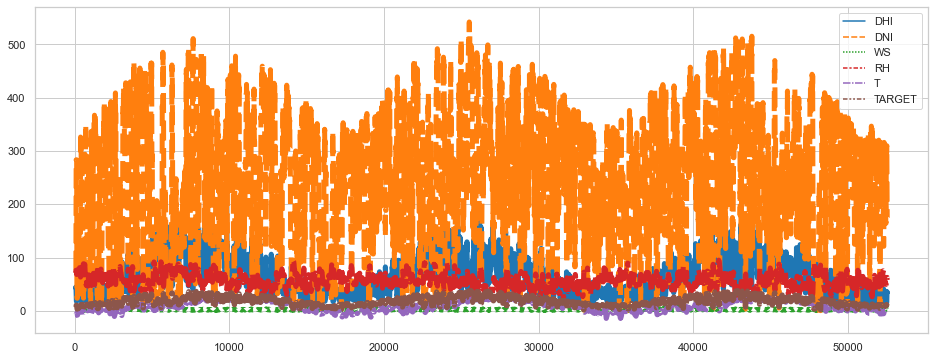

In [10]:
data = df.rolling(50).mean()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))
sns.lineplot(data=data, palette="tab10", linewidth=5)

In [11]:
# df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()

In [12]:
df.head()

,DHI,DNI,WS,RH,T,TARGET
0,0,0,1.5,69.08,-12,0.0
1,0,0,1.5,69.06,-12,0.0
2,0,0,1.6,71.78,-12,0.0
3,0,0,1.6,71.75,-12,0.0
4,0,0,1.6,75.20,-12,0.0


In [13]:
drop_columns = []
for col in df.columns: # avoid deviding by zero during normalization
    if df[col].max()==df[col].min():
        drop_columns.append(col)
df=(df-df.min())/(df.max()-df.min())  # Normalization

num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [14]:
df.head()

,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.125000,0.665404,0.12963,0.0
1,0.0,0.0,0.125000,0.665188,0.12963,0.0
2,0.0,0.0,0.133333,0.694622,0.12963,0.0
3,0.0,0.0,0.133333,0.694297,0.12963,0.0
4,0.0,0.0,0.133333,0.731631,0.12963,0.0


## 1. Indexex and offsets

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['TARGET']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [17]:
def plot(self, model=None, plot_col='TARGET', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [18]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    

  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=2*24, # daily sliding  
      shuffle=False,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Input Size = 7days of data = 7 x 24 x 2 <br>
Output Size = 2days of prediction = 2 x 24 x 2 

No example batch was found, so get one from the `.train` dataset


Total window size: 432
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

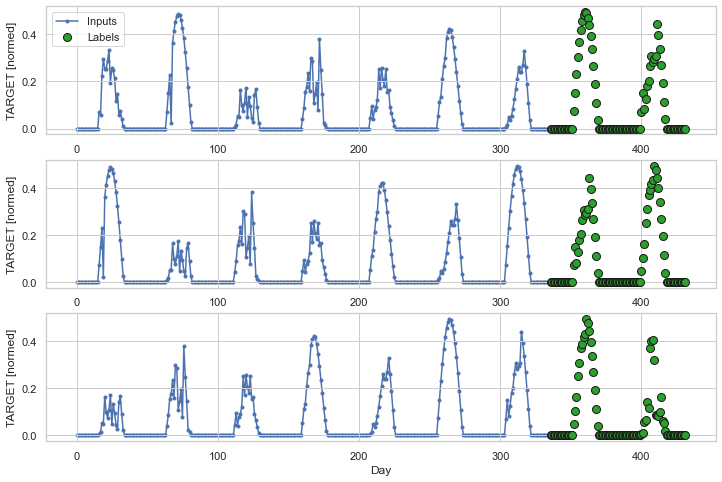

In [44]:
IN_STEPS = 7*24*2
OUT_STEPS = 2*24*2

multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['TARGET'],
                              train_df=train_df, val_df=val_df, test_df=test_df,)

multi_window.plot()
multi_window

In [21]:
def compile_and_fit(model, window, patience=5, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

val_performance = {}
performance = {}

In [22]:
def plot_history(history_object, plot_columns = train_wo_date.columns):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

In [23]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.Dense(15),
    tf.keras.layers.GRU(30, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(30), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

Epoch 1/30
12/12 [==============================] - 8s 648ms/step - loss: 0.0801 - mean_absolute_error: 0.1801 - val_loss: 0.1469 - val_mean_absolute_error: 0.2849
Epoch 2/30
12/12 [==============================] - 9s 766ms/step - loss: 0.0481 - mean_absolute_error: 0.1428 - val_loss: 0.1811 - val_mean_absolute_error: 0.3493
Epoch 3/30
12/12 [==============================] - 7s 610ms/step - loss: 0.0284 - mean_absolute_error: 0.1068 - val_loss: 0.1967 - val_mean_absolute_error: 0.3737
Epoch 4/30
12/12 [==============================] - 9s 719ms/step - loss: 0.0207 - mean_absolute_error: 0.0891 - val_loss: 0.2132 - val_mean_absolute_error: 0.3928
Epoch 5/30
12/12 [==============================] - 7s 564ms/step - loss: 0.0187 - mean_absolute_error: 0.0850 - val_loss: 0.2242 - val_mean_absolute_error: 0.4062
Epoch 6/30
12/12 [==============================] - 8s 644ms/step - loss: 0.0180 - mean_absolute_error: 0.0826 - val_loss: 0.2347 - val_mean_absolute_error: 0.4169


KeyError: 'DHI'

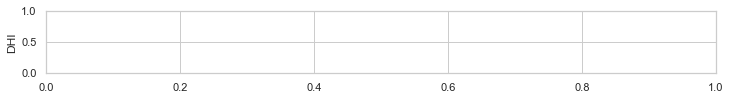

In [24]:
history = compile_and_fit(multi_gru_model, multi_window, epochs=30)
plot_history(history)

4/4 [==============================] - 0s 118ms/step - loss: 0.2347 - mean_absolute_error: 0.4169


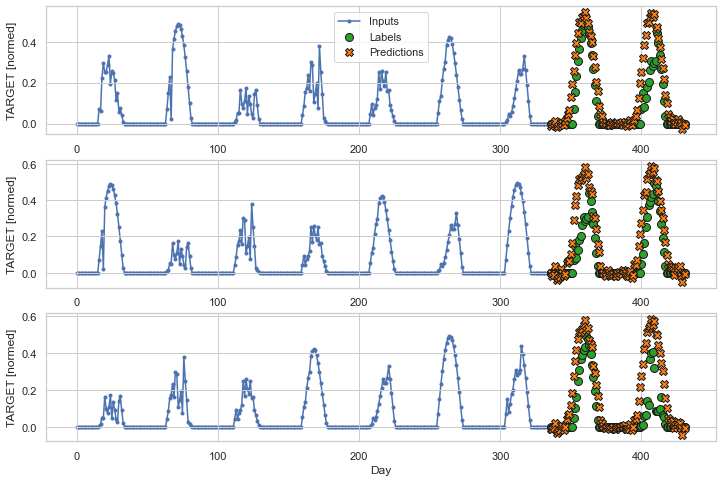

In [25]:
val_performance['M_GRU'] = multi_gru_model.evaluate(multi_window.val)
performance['M_GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

Epoch 1/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0463 - mean_absolute_error: 0.1275 - val_loss: 0.1772 - val_mean_absolute_error: 0.3384
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 0.0206 - mean_absolute_error: 0.0834 - val_loss: 0.1861 - val_mean_absolute_error: 0.3645
Epoch 3/100
12/12 [==============================] - 0s 33ms/step - loss: 0.0189 - mean_absolute_error: 0.0780 - val_loss: 0.1808 - val_mean_absolute_error: 0.3517
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 0.0175 - mean_absolute_error: 0.0751 - val_loss: 0.1800 - val_mean_absolute_error: 0.3536
Epoch 5/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0172 - mean_absolute_error: 0.0743 - val_loss: 0.1772 - val_mean_absolute_error: 0.3483
Epoch 6/100
12/12 [==============================] - 1s 43ms/step - loss: 0.0189 - mean_absolute_error: 0.0765 - val_loss: 0.1838 - val_mean_absolute_error: 0.3572
Epoch 7/100
12/1

KeyError: 'DHI'

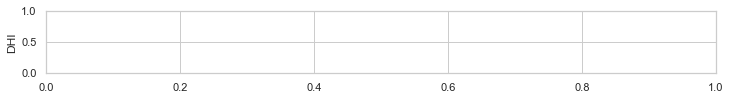

In [26]:
CONV_WIDTH = IN_STEPS
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=100)
plot_history(history)

4/4 [==============================] - 0s 8ms/step - loss: 0.1585 - mean_absolute_error: 0.3149


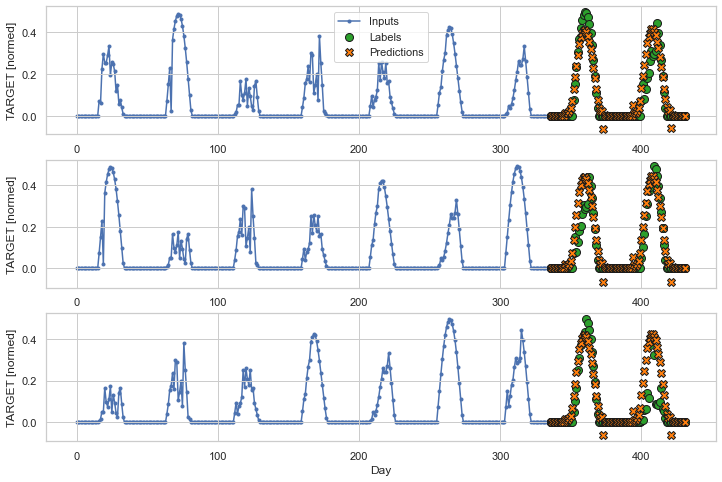

In [27]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [28]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [29]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

prediction.shape (64, 6)
Output shape (batch, time, features):  (64, 96, 6)


Epoch 1/200
12/12 [==============================] - 8s 687ms/step - loss: 0.0882 - mean_absolute_error: 0.1806 - val_loss: 0.0969 - val_mean_absolute_error: 0.2246
Epoch 2/200
12/12 [==============================] - 4s 307ms/step - loss: 0.0700 - mean_absolute_error: 0.2078 - val_loss: 0.0863 - val_mean_absolute_error: 0.2312
Epoch 3/200
12/12 [==============================] - 4s 312ms/step - loss: 0.0664 - mean_absolute_error: 0.2014 - val_loss: 0.0827 - val_mean_absolute_error: 0.2399
Epoch 4/200
12/12 [==============================] - 4s 357ms/step - loss: 0.0648 - mean_absolute_error: 0.2118 - val_loss: 0.0824 - val_mean_absolute_error: 0.2407
Epoch 5/200
12/12 [==============================] - 5s 428ms/step - loss: 0.0645 - mean_absolute_error: 0.2063 - val_loss: 0.0828 - val_mean_absolute_error: 0.2383
Epoch 6/200
12/12 [==============================] - 5s 456ms/step - loss: 0.0642 - mean_absolute_error: 0.2067 - val_loss: 0.0825 - val_mean_absolute_error: 0.2411
Epoch 7/20

KeyError: 'DHI'

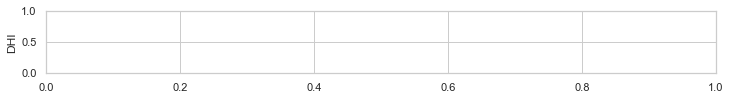

In [30]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

Epoch 1/100
12/12 [==============================] - 22s 2s/step - loss: 0.1366 - mean_absolute_error: 0.2731 - val_loss: 0.1067 - val_mean_absolute_error: 0.2814
Epoch 2/100
12/12 [==============================] - 19s 2s/step - loss: 0.0692 - mean_absolute_error: 0.2133 - val_loss: 0.1025 - val_mean_absolute_error: 0.2482
Epoch 3/100
12/12 [==============================] - 19s 2s/step - loss: 0.0645 - mean_absolute_error: 0.2017 - val_loss: 0.0966 - val_mean_absolute_error: 0.2552
Epoch 4/100
12/12 [==============================] - 19s 2s/step - loss: 0.0632 - mean_absolute_error: 0.2069 - val_loss: 0.0966 - val_mean_absolute_error: 0.2512
Epoch 5/100
12/12 [==============================] - 19s 2s/step - loss: 0.0629 - mean_absolute_error: 0.2019 - val_loss: 0.0969 - val_mean_absolute_error: 0.2524
Epoch 6/100
12/12 [==============================] - 18s 2s/step - loss: 0.0625 - mean_absolute_error: 0.2025 - val_loss: 0.0973 - val_mean_absolute_error: 0.2549
Epoch 7/100
12/12 [===

KeyError: 'DHI'

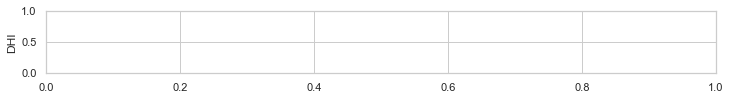

In [32]:
# ref:
# https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1
# https://machinelearningmastery.com/lstm-autoencoders/
window_length = IN_STEPS
output_length = OUT_STEPS
feats = 6

autoencoder_model = tf.keras.Sequential([
#     keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'), 
    keras.layers.RepeatVector(output_length, name='encoder_decoder_bridge'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'),
    keras.layers.TimeDistributed(keras.layers.Dense(feats))
                          ])


# autoencoder_model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history_encode = compile_and_fit(autoencoder_model, multi_window, epochs=100)
plot_history(history_encode)

4/4 [==============================] - 1s 249ms/step - loss: 0.0982 - mean_absolute_error: 0.2576


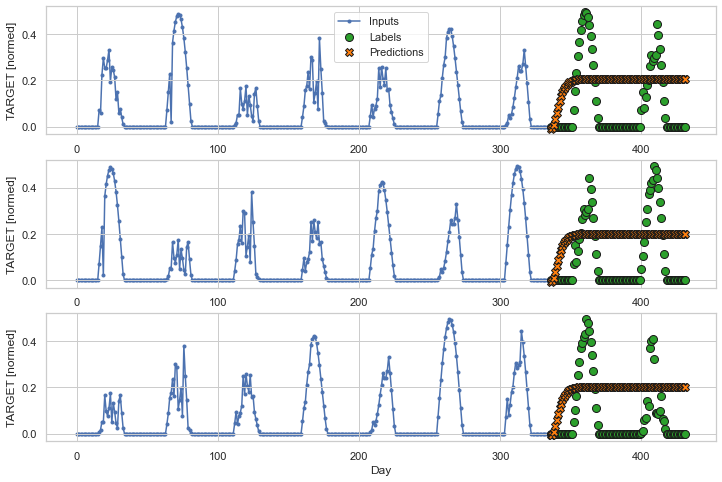

In [34]:
val_performance['Encoder'] = autoencoder_model.evaluate(multi_window.val)
performance['Encoder'] = autoencoder_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(autoencoder_model)

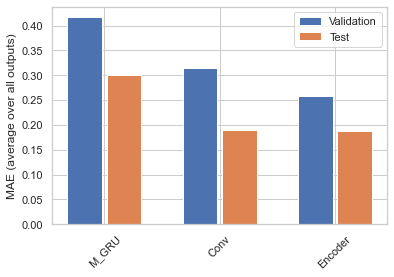

In [35]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_gru_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()